Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:

- Download the corpora and split it in training and test sets, structuring a dataframe.
- Embed the words using GloVe embeddings
- Create a baseline model, using a simple neural architecture
- Experiment doing small modifications to the model
- Evaluate your best model
- Analyze the errors of your model
- Corpora: Ignore the numeric value in the third column, use only the words/symbols and its label. https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

Splits: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

Baseline: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

Modifications: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

Training and Experiments: all the experiments must involve only the training and validation sets.

Evaluation: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

Error Analysis (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

Report: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip

# Sequence labeling

In [353]:
import re
import random
import time
import copy
import string
from functools import partial
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchcrf import CRF
from tqdm.notebook import tqdm
from nltk.corpus import dependency_treebank

import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.xmargin'] = .05
plt.rcParams['axes.ymargin'] = .05
plt.style.use('ggplot')

## Introduction

First of all, let's download the dependency treebank dataset from the NLTK data module$\dots$

In [4]:
dataset_name = "dependency_treebank"

try:
    nltk.data.find(dataset_name)
except LookupError:
    nltk.download(dataset_name)

[nltk_data] Downloading package dependency_treebank to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package dependency_treebank is already up-to-date!


Now we may want to fix all the possible sources of randomness, in order to achieve reproducible results.

In [5]:
RANDOM_SEED = 42


def fix_random(seed):
    """
    Fix all the possible sources of randomness
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


fix_random(RANDOM_SEED)

## Data preparation

In this code section, each and every file in the dependency treebank dataset will be loaded and corresponding sentences will be splitted with the following reasoning:
- Training set range: from file `wsj_0001.dp` to `wsj_0100.dp`
- Validation set range: from file `wsj_0101.dp` to `wsj_0150.dp`
- Test set range: from file `wsj_0151.dp` to `wsj_0199.dp`

In [6]:
file_prefix = "wsj_"
file_ext = ".dp"
train_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(1, 101)]
val_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(101, 151)]
test_files = [f"{file_prefix}{i:04d}{file_ext}" for i in range(151, 200)]
splits = (
    ["train"] * len(train_files) + ["val"] * len(val_files) + ["test"] * len(test_files)
)
whole_files = train_files + val_files + test_files

In [7]:
whole_files[0:-1:20]

['wsj_0001.dp',
 'wsj_0021.dp',
 'wsj_0041.dp',
 'wsj_0061.dp',
 'wsj_0081.dp',
 'wsj_0101.dp',
 'wsj_0121.dp',
 'wsj_0141.dp',
 'wsj_0161.dp',
 'wsj_0181.dp']

Let's check how are sentences encoded in each file$\dots$

In [8]:
dependency_treebank.raw(fileids=whole_files[0])

'Pierre\tNNP\t2\nVinken\tNNP\t8\n,\t,\t2\n61\tCD\t5\nyears\tNNS\t6\nold\tJJ\t2\n,\t,\t2\nwill\tMD\t0\njoin\tVB\t8\nthe\tDT\t11\nboard\tNN\t9\nas\tIN\t9\na\tDT\t15\nnonexecutive\tJJ\t15\ndirector\tNN\t12\nNov.\tNNP\t9\n29\tCD\t16\n.\t.\t8\n\nMr.\tNNP\t2\nVinken\tNNP\t3\nis\tVBZ\t0\nchairman\tNN\t3\nof\tIN\t4\nElsevier\tNNP\t7\nN.V.\tNNP\t12\n,\t,\t12\nthe\tDT\t12\nDutch\tNNP\t12\npublishing\tVBG\t12\ngroup\tNN\t5\n.\t.\t3\n'

It seems that each sentence is subdivided in triples that follow the pattern `token \t tag \t number \n`, where `\t` is the tab symbol and `\n` the newline one. Since we are only interested in tokens and tags, we can simply discard the last number encountered in the triples in each line of a sentence. Moreover, we can observe that different sentences in the same file are separated by a blank character (i.e. `""`), which we can exploit to build our dataset.

In [9]:
def split_into_sentences(splitted_file_str, split_token):
    """
    Split the given file string into sentences, by splitting on
    a specific token (e.g. the empty token)
    """
    sentences = []
    start_indexes = [0]
    for i, elem in enumerate(splitted_file_str):
        if elem == split_token:
            sentences.append(splitted_file_str[start_indexes[len(sentences)] : i])
            start_indexes.append(i + 1)
    return sentences


def parse_file(fileid, preprocessor=None, split_sentences=False, split_token=""):
    """
    Parse the given file identifier from the dependency treebank corpus
    and return a tuple (`tokens`, `tags`), s.t.
        - `tokens` and `tags` are 1D lists containing the tokens and
           their associated tags in the entire document
           (applied when `split_sentences` is False)
        - `tokens` and `tags` are 2D lists, where each sublist contains
           tokens and tags of a single sentence in the document
           (applied when `split_sentences` is True)
    
    If you wish to preprocess tokens, you can pass a function to the
    `preprocessor` argument, which should take as input only the token
    to transform
    """
    file_str = dependency_treebank.raw(fileids=fileid).split("\n")
    sentences = [file_str]
    if split_sentences:
        sentences = split_into_sentences(file_str, split_token=split_token)
    if preprocessor is None:
        preprocessor = lambda t: t
    tokens, tags = [], []
    for sentence in sentences:
        sentence_tokens, sentence_tags = [], []
        for triple in sentence:
            splitted_triple = triple.split("\t")
            token = preprocessor(splitted_triple[0])
            if token != split_token:
                tag = splitted_triple[1]
                sentence_tokens.append(token)
                sentence_tags.append(tag)
        if len(sentence_tokens) > 0:
            tokens.append(sentence_tokens)
            tags.append(sentence_tags)
    return tokens, tags


def parse_files(fileids, preprocessor=None, split_sentences=False, split_token=""):
    """
    Parse a set of file identifiers from the dependency treebank corpus
    and return two lists, one which contains lists of tokens and one 
    containing lists of corresponding tags for each sentence
    """
    tokens_list, tags_list = [], []
    for fileid in fileids:
        tokens, tags = parse_file(
            fileid, preprocessor=preprocessor, split_sentences=split_sentences
        )
        tokens_list.append(tokens)
        tags_list.append(tags)
    return tokens_list, tags_list

In order to have a lower number of OOV words w.r.t. the embeddings that we will use next, we are going to perform a gentle preprocessing of each token.

In [10]:
def preprocess_token(token):
    """
    Peform small modifications to the given token:
        - Transform to lowercase
        - Encode numbers as "<num>"
    """
    token = token.lower()
    token = "<num>" if re.match(utils.FLOAT_RE, token) else token
    return token

Below we are extracting two lists from the raw dataset:
- `whole_tokens`, which is a 3D list containing documents as the first dimension, then sentences as the second dimension and tokens as the third and final dimension
- `whole tags`, which is a list parallel to `whole_tokens`, where the only difference lies in the final dimension, containing tags instead of tokens

In [11]:
whole_tokens, whole_tags = parse_files(
    whole_files, preprocessor=preprocess_token, split_sentences=True, split_token=""
)
whole_sentences_tokens = [
    sentence for document in whole_tokens for sentence in document
]
whole_sentences_tags = [
    sentence_tags for document in whole_tags for sentence_tags in document
]

Now we can build our initial DataFrame, with the following columns:
- `tokens`: the list of tokens in a sentence
- `tags`: the list of tags associated to each token in a sentence
- `split`: the split (`train`, `val` or `test`) associated to a particular example
- `fileid`: the file identifier associated to each sentence

In [12]:
df = pd.DataFrame(
    {
        "tokens": whole_sentences_tokens,
        "tags": whole_sentences_tags,
        "split": [
            split
            for i, sentence in enumerate(whole_tokens)
            for split in [splits[i]] * len(sentence)
        ],
        "fileid": [
            fileid
            for i, sentence in enumerate(whole_tokens)
            for fileid in [whole_files[i]] * len(sentence)
        ],
    }
)
df.head()

,tokens,tags,split,fileid
0,"[pierre, vinken, ,, <num>, years, old, ,, will...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train,wsj_0001.dp
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train,wsj_0001.dp
2,"[rudolph, agnew, ,, <num>, years, old, and, fo...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train,wsj_0002.dp
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train,wsj_0003.dp
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train,wsj_0003.dp


Let's see how many sentences do we have in each learning split$\dots$

In [13]:
df["split"].value_counts()

train    1963
val      1299
test      652
Name: split, dtype: int64

## Data exploration

After extracting the tags and tokens for each sentence of the whole dataset, we may want to observe what their distributions look like (e.g. check the most frequent tags).

In [14]:
def flatten(a):
    """
    Given a multidimensional list, returns its flattened version
    """
    if isinstance(a, (list, tuple, set, range)):
        for s in a:
            yield from flatten(s)
    else:
        yield a


def get_col(df, col_name, split=None, split_col_name="split"):
    """
    Returns a list obtained by concatenating the lists of each row,
    in a specific column of the given DataFrame
    """
    return (
        df[df[split_col_name] == split][col_name] if split is not None else df[col_name]
    ).tolist()


def get_unique(df, col_name, split=None, split_col_name="split"):
    """
    Returns the unique values found in a DataFrame column
    composed of lists
    """
    assert isinstance(df.loc[0, col_name], list)
    selection = get_col(df, col_name, split=split, split_col_name=split_col_name)
    return np.unique(list(flatten(selection)))

How many unique tags do we have to deal with?

In [15]:
unique_tags = get_unique(df, "tags")
print(f"There are {len(unique_tags)} unique tags in the dataset")

There are 45 unique tags in the dataset


What are the 10 most frequent tags?

In [18]:
tags_fd = nltk.probability.FreqDist(flatten(whole_tags))
tags_fd.most_common(10)

[('NN', 13166),
 ('IN', 9857),
 ('NNP', 9410),
 ('DT', 8165),
 ('NNS', 6047),
 ('JJ', 5834),
 (',', 4886),
 ('.', 3874),
 ('CD', 3546),
 ('VBD', 3043)]

What is the distribution of the whole set of tags?

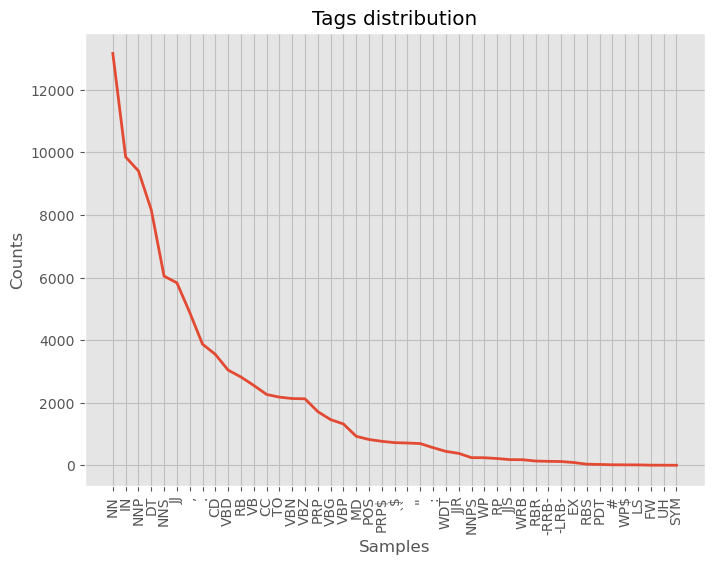

In [19]:
tags_fd.plot(title="Tags distribution", cumulative=False)
plt.show()

How many unique tokens does our dataset have?

In [20]:
unique_tokens = get_unique(df, "tokens")
print(f"There are {len(unique_tokens)} unique tokens in the dataset")

There are 9964 unique tokens in the dataset


What are the 10 most used tokens?

In [21]:
tokens_fd = nltk.probability.FreqDist(flatten(whole_tokens))
tokens_fd.most_common(10)

[(',', 4885),
 ('the', 4764),
 ('.', 3828),
 ('<num>', 2471),
 ('of', 2325),
 ('to', 2182),
 ('a', 1988),
 ('in', 1769),
 ('and', 1556),
 ("'s", 865)]

What is the distribution of the top 50 tokens with greatest frequency?

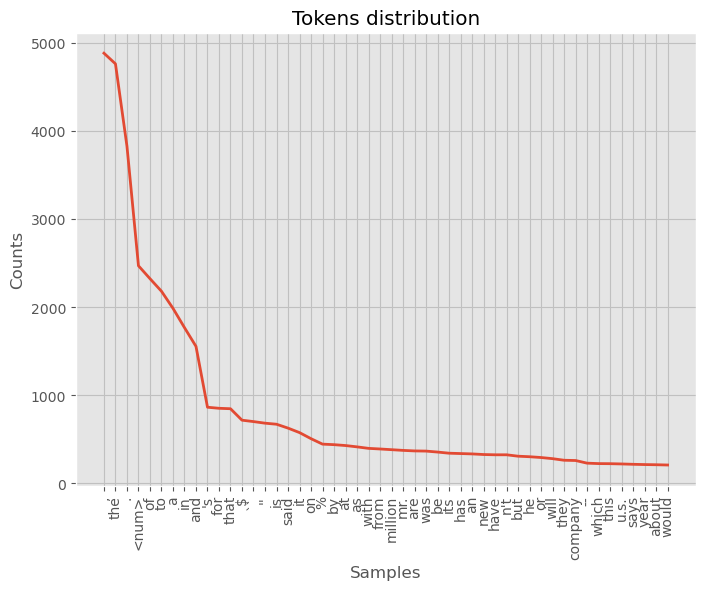

In [22]:
tokens_fd.plot(50, title="Tokens distribution", cumulative=False)
plt.show()

## Vocabularies

The first thing that we have to do is to build two vocabularies, one for tokens and one for tags. The important things about the vocabulary building procedure are mainly two:
1. It must be a deterministic method, i.e. it must output the same result when given the same input
2. The first index of the produced vocabulary (i.e. index zero), must contain the padding token, which will be used at training time to pad sequences in the same batch to be of the same lenght

In [23]:
Vocabulary = namedtuple(
    "Vocabulary", ["to_string", "from_string", "string"]
)

In [24]:
def build_vocabulary(tokens, padding_token="0"):
    """
    Given a list of strings, builds the corresponding Vocabulary object
    """
    assert padding_token not in tokens
    words = sorted(set(tokens))
    vocabulary, inverse_vocabulary, neighbors = dict(), dict(), dict()
    vocabulary[0] = str(padding_token)
    inverse_vocabulary[str(padding_token)] = 0
    for i, w in tqdm(enumerate(words)):
        vocabulary[i + 1] = w
        inverse_vocabulary[w] = i + 1
    return Vocabulary(
        to_string=vocabulary,
        from_string=inverse_vocabulary,
        string=[padding_token] + words,
    )

Since we want to use the same padding token for both words and tags, we have to check that this token does not appear in our unique lists of tokens and tags$\dots$ 

In [25]:
PADDING_TOKEN = "0"
is_token = PADDING_TOKEN in unique_tokens
is_tag = PADDING_TOKEN in unique_tags
print(
    f"Is the padding token in one of the two unique lists of tokens or tags? {is_token or is_tag}"
)

Is the padding token in one of the two unique lists of tokens or tags? False


We will use the padding token `"0"`, since it fulfills our requirements. 

**Note**: We are cheating a little bit, since we are allowing ourselves to have a look at the entire dataset to use a single padding token, which is something wrong, but convenient in this specific case.

In [26]:
tokens_vocabulary = build_vocabulary(unique_tokens, padding_token=PADDING_TOKEN)
tags_vocabulary = build_vocabulary(unique_tags, padding_token=PADDING_TOKEN)

Let's check the vocabulary to see what it looks like$\dots$

In [27]:
list(tokens_vocabulary.to_string.items())[:10]

[(0, '0'),
 (1, '!'),
 (2, '#'),
 (3, '$'),
 (4, '%'),
 (5, '&'),
 (6, "'"),
 (7, "''"),
 (8, "'30s"),
 (9, "'40s")]

In [28]:
list(tags_vocabulary.to_string.items())[:10]

[(0, '0'),
 (1, '#'),
 (2, '$'),
 (3, "''"),
 (4, ','),
 (5, '-LRB-'),
 (6, '-RRB-'),
 (7, '.'),
 (8, ':'),
 (9, 'CC')]

Finally, we can update our DataFrame by adding the following columns:
- `indexed_tokens`: the list of indexes of each word in the sentence, taken from the previously built words vocabulary
- `indexed_tags`: the list of indexes of each tag in the sentence, taken from the previously built tags vocabulary

In [29]:
def to_indexes(values, to_index):
    """
    Given a list of keys and a dictionary indexed by those keys,
    return the corresponding values in the dictionary
    """
    return [to_index[v] for v in values]


df["indexed_tokens"] = list(
    map(lambda s: to_indexes(s, tokens_vocabulary.from_string), whole_sentences_tokens,)
)
df["indexed_tags"] = list(
    map(lambda s: to_indexes(s, tags_vocabulary.from_string), whole_sentences_tags,)
)
df.head()

,tokens,tags,split,fileid,indexed_tokens,indexed_tags
0,"[pierre, vinken, ,, <num>, years, old, ,, will...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train,wsj_0001.dp,"[6562, 9557, 20, 40, 9919, 6130, 20, 9793, 474...","[21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14,..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train,wsj_0001.dp,"[5755, 9557, 4676, 1462, 6095, 2953, 5808, 20,...","[21, 21, 40, 20, 14, 21, 21, 4, 11, 21, 37, 20..."
2,"[rudolph, agnew, ,, <num>, years, old, and, fo...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train,wsj_0002.dp,"[7695, 256, 20, 40, 9919, 6130, 394, 3607, 146...","[21, 21, 4, 10, 23, 15, 9, 15, 20, 14, 21, 21,..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train,wsj_0003.dp,"[45, 3601, 6095, 570, 6146, 9453, 9063, 5302, ...","[11, 20, 14, 20, 28, 38, 33, 35, 21, 20, 23, 4..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train,wsj_0003.dp,"[8966, 570, 3437, 20, 2159, 20, 4676, 9420, 74...","[11, 20, 20, 4, 20, 4, 40, 28, 15, 14, 26, 40,..."


## Dataset and DataLoader

In order to correctly work with batches and sequences of different lenght inside of each batch, we need to exploit the objects made available by PyTorch. In particular, we need to wrap our `DataFrame` inside a custom `Dataset` subclass, which will be used later as an input for a `DataLoader` object, that will automatically handle the generation of batches from our examples. 

In [30]:
class DependencyTreebankDataset(Dataset):
    """
    Dependency treebank dataset for POS tagging
    """

    def __init__(self, df):
        self.df = df.copy()
        self.df = self.df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        assert isinstance(index, int)
        tokens = self.df.loc[index, "indexed_tokens"]
        tags = self.df.loc[index, "indexed_tags"]
        return tokens, tags

We will build and store three different `Dataset` objects, based on the split parameter of the previously built DataFrame, which will be used in different stages of the learning process, i.e. training, validation and testing.

In [31]:
train_dataset = DependencyTreebankDataset(df[df["split"] == "train"])
val_dataset = DependencyTreebankDataset(df[df["split"] == "val"])
test_dataset = DependencyTreebankDataset(df[df["split"] == "test"])

Let's see if our `Dataset` building process worked out nicely, by checking the first example in the training dataset$\dots$

In [32]:
print(train_dataset[0])

([6562, 9557, 20, 40, 9919, 6130, 20, 9793, 4749, 8966, 1013, 568, 45, 5988, 2554, 6028, 40, 27], [21, 21, 4, 10, 23, 15, 4, 19, 35, 11, 20, 14, 11, 15, 20, 21, 10, 7])


As already mentioned, the `DataLoader` object will be used to automatically handle the generation of batches (with the specified batch size) from the entire list of examples$\dots$ 

Another important aspect of `DataLoader`s is that they enable us to pad sequences in the same batch to be of the same lenght (i.e. the lenght of the longest sequence in the batch), by using the previously defined padding token. To do so, we leverage PyTorch's `pad_sequence` function.

In [33]:
def pad_batch(batch, padding_token="0"):
    """
    This function expects to receive a list of tuples (i.e. a batch),
    s.t. each tuple contains tokens and tags for one sentence in the batch
    and returns the same sequences padded with the padding token
    """
    (tokens, tags) = zip(*batch)
    tokens_lenghts = [len(x) for x in tokens]
    tags_lenghts = [len(y) for y in tags]
    padded_tokens = pad_sequence(
        [torch.tensor(t) for t in tokens],
        batch_first=True,
        padding_value=int(padding_token),
    )
    padded_tags = pad_sequence(
        [torch.tensor(t) for t in tags],
        batch_first=True,
        padding_value=int(padding_token),
    )
    return padded_tokens, padded_tags, tokens_lenghts, tags_lenghts

Below we are setting the `batch_size` hyperparameter to a fixed value, shared between every instance of our `DataLoader` objects. We can experiment with this value a little bit, but we don't want it to be neither too small (since small batches are noisy) nor too big (since it is constrained by the minimum size of the three splits).

In [34]:
BATCH_SIZE = 8

In [35]:
default_dataloader = partial(
    DataLoader,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=partial(pad_batch, padding_token=PADDING_TOKEN),
    pin_memory=True,
)

As we did with the `Dataset` wrapper, we will store three different `DataLoader` objects, one for each learning stage.

In [36]:
train_dataloader = default_dataloader(train_dataset)
val_dataloader = default_dataloader(val_dataset)
test_dataloader = default_dataloader(test_dataset)

## Word embeddings

The way we represent words in sequence labeling models is still using word embeddings, exploiting methods like `Word2vec` or `GloVe`. In this whole notebook, we will leverage `GloVe` pre-trained embeddings with a fixed dimensionality (e.g. `50`), as given by the `Gensim` library. 

Because of this, we need to build our embedding matrix, i.e. a matrix $E$ of size $w\times d$, where $w$ is the number of unique words in our dataset and $d$ is the dimensionality of word embeddings (in our example $d=50$). In order to correctly build the embedding matrix, we need a way to handle OOV (Out Of Vocabulary) words, i.e. words that appear in our dataset but not on the dataset on which the embeddings were trained on. We will try different OOV handling methods:
- `uniform`: the OOV word vector is sampled from a uniform distribution in a specific range (e.g. $[-1,1]$)
- `normal`: the OOV word vector is sampled from a normal distribution (i.e. a Gaussian with $\mu=0$ and $\sigma=1$)
- `mean`: the OOV word vector is taken as the average of the not OOV word vectors represented by neighbors of the analyzed word (e.g. considering a window size of $1$)

Another great OOV method would be to estimate the OOV word vector by a recurrent model, using subword information (i.e. using characters as inputs instead of words).

Moreover, we also zero-out the word vector associated with the padding token.

In [37]:
EMBEDDING_DIMENSION = 300

In [38]:
embedding_model = utils.load_embedding_model(
    "glove", embedding_dimension=EMBEDDING_DIMENSION
)

So, first of all, let's check the number of OOV words for each split (i.e. training, validation and test)$\dots$

In [184]:
def check_oov_terms(embedding_model, word_listing):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms
    """
    oov_terms = set()
    for word in word_listing:
        if word not in embedding_model.vocab:
            oov_terms.add(word)
    return oov_terms

We have to once again store the unique tokens associated to each different split$\dots$

In [185]:
get_unique_tokens = partial(get_unique, df, "tokens", split_col_name="split")
unique_train_tokens = get_unique_tokens(split="train")
unique_val_tokens = get_unique_tokens(split="val")
unique_test_tokens = get_unique_tokens(split="test")

In [186]:
print(f"There are {len(unique_train_tokens)} unique tokens in the training set")
print(f"There are {len(unique_val_tokens)} unique tokens in the validation set")
print(f"There are {len(unique_test_tokens)} unique tokens in the test set")

There are 6930 unique tokens in the training set
There are 4990 unique tokens in the validation set
There are 3043 unique tokens in the test set


And now we can finally see the percentage of OOV words in each split w.r.t. our embedding model.

In [187]:
train_oov_terms = check_oov_terms(embedding_model, unique_train_tokens)
val_oov_terms = check_oov_terms(embedding_model, unique_val_tokens)
test_oov_terms = check_oov_terms(embedding_model, unique_test_tokens)
seq_val_oov_terms = val_oov_terms - train_oov_terms
seq_test_oov_terms = test_oov_terms - train_oov_terms - val_oov_terms
print(
    f"Total training OOV terms: {len(train_oov_terms)} ({round(len(train_oov_terms) / len(unique_train_tokens), 2)}%)"
)
print(
    f"Total validation OOV terms: {len(seq_val_oov_terms)} ({round(len(seq_val_oov_terms) / len(unique_val_tokens), 2)}%)"
)
print(
    f"Total testing OOV terms: {len(seq_test_oov_terms)} ({round(len(seq_test_oov_terms) / len(unique_test_tokens), 2)}%)"
)

Total training OOV terms: 295 (0.04%)
Total validation OOV terms: 141 (0.03%)
Total testing OOV terms: 72 (0.02%)


Fortunately, OOV words are not that many, so that even associating a random word vector to those tokens shouldn't have a big impact on our extrinsic evaluation.

Note that the way we compute OOV words is sequential, i.e. an OOV word in the training set is not considered OOV anymore neither in the validation split nor in the test one (and the same consideration can be applied for an OOV word in the validation split, which is not OOV anymore in the test split, since its embedding has been already computed).

Anyway, since we want to use the `mean` method for building embedding matrices, we need to compute a separate list of neighbors for each token in each split of the data (to simulate a co-occurrence matrix)$\dots$

In [188]:
def build_neighbors(tokens, sentences, vocabulary, window_size=1, padding_token="0"):
    """
    Build a list of neighbors for each token, where neighbors are searched
    in the given document list.
    It returns a dictionary, indexed by the index of each token in the given
    vocabulary, where the value is a list of indexes representing neighbors
    """
    assert isinstance(vocabulary, Vocabulary)
    neighbors = {vocabulary.from_string[padding_token]: []}
    for sentence in tqdm(sentences):
        for i, central_word in enumerate(sentence):
            central_word_index = vocabulary.from_string[central_word]
            context = (
                sentence[max(0, i - window_size) : i]
                + sentence[i + 1 : min(i + window_size + 1, len(sentence))]
            )
            for context_word in context:
                context_word_index = vocabulary.from_string[context_word]
                neighbors.setdefault(central_word_index, []).append(context_word_index)
    return neighbors

We have to once again store the sentences associated to each different split$\dots$

In [189]:
get_sentences = partial(get_col, df, "tokens", split_col_name="split")
train_sentences = get_sentences(split="train")
val_sentences = get_sentences(split="val")
test_sentences = get_sentences(split="test")

And then we can compute the actual neighbors for each token in each split$\dots$

In [190]:
neighbors = partial(
    build_neighbors,
    vocabulary=tokens_vocabulary,
    window_size=1,
    padding_token=PADDING_TOKEN,
)
train_neighbors = neighbors(unique_train_tokens, train_sentences)
val_neighbors = neighbors(unique_val_tokens, val_sentences)
test_neighbors = neighbors(unique_test_tokens, test_sentences)

Now we are going to build three different embedding matrices, one for each split (i.e. training, validation and test). As already mentioned, the main method to handle OOV words will be `mean` and the embeddings will be computed in an incremental fashion. In particular, we are going to patch each embedding matrix following the training one with the previously calculated set of OOV embeddings.

In [191]:
def build_embedding_matrix(
    embedding_model,
    embedding_dimension,
    vocabulary,
    tokens,
    oov_terms,
    neighbors=None,
    method="mean",
):
    """
    Builds the embedding matrix of a specific dataset given a pre-trained Gensim word embedding model
    """
    assert method in ("uniform", "normal", "mean")
    assert method != "mean" or (method == "mean" and neighbors is not None)

    def uniform_embedding(interval=(-1, 1)):
        return interval[0] + np.random.sample(embedding_dimension) + interval[1]

    def normal_embedding():
        return np.random.normal(embedding_dimension)

    embedding_matrix = np.zeros((len(vocabulary.string), embedding_dimension))
    for word in tokens:
        word_index = vocabulary.from_string[word]
        word_vector = np.zeros((1, embedding_dimension))
        # Words that are no OOV are taken from the Gensim model
        if word not in oov_terms:
            word_vector = embedding_model[word]
        # OOV words computed as the mean word vector of their neighbors
        elif method == "mean":
            neighboring_wvs = []
            for neighbor_index in neighbors[word_index]:
                neighbor = vocabulary.to_string[neighbor_index]
                if neighbor not in oov_terms:
                    neighboring_wvs.append(embedding_model[neighbor])
            # If there is at least one neighbor, compute the mean of their word vectors
            if len(neighboring_wvs) > 1:
                word_vector = np.mean(neighboring_wvs, axis=0)
            # Otherwise, resort to random normal vectors
            else:
                word_vector = normal_embedding()
        # OOV words computed as random normal vectors
        elif method == "normal":
            word_vector = normal_embedding()
        # OOV words computed as uniform vectors in range [-1, 1]
        elif method == "uniform":
            word_vector = uniform_embedding()
        embedding_matrix[word_index, :] = word_vector
    return embedding_matrix

First of all, we are going to build the embedding matrix for the training split$\dots$

In [192]:
train_embeddings = build_embedding_matrix(
    embedding_model,
    EMBEDDING_DIMENSION,
    tokens_vocabulary,
    unique_train_tokens,
    train_oov_terms,
    neighbors=train_neighbors,
    method="mean",
)

Let's check an example word vector, given by a high frequency word like `"the"`$\dots$

In [193]:
train_embeddings[tokens_vocabulary.from_string["the"]]

array([ 4.65600006e-02,  2.13180006e-01, -7.43639981e-03, -4.58539993e-01,
       -3.56389992e-02,  2.36430004e-01, -2.88360000e-01,  2.15210006e-01,
       -1.34859994e-01, -1.64129996e+00, -2.60910004e-01,  3.24340016e-02,
        5.66210002e-02, -4.32960019e-02, -2.16719992e-02,  2.24759996e-01,
       -7.51290023e-02, -6.70180023e-02, -1.42470002e-01,  3.88250016e-02,
       -1.89510003e-01,  2.99769998e-01,  3.93049985e-01,  1.78870007e-01,
       -1.73429996e-01, -2.11779997e-01,  2.36169994e-01, -6.36809990e-02,
       -4.23180014e-01, -1.16609998e-01,  9.37540010e-02,  1.72959998e-01,
       -3.30729991e-01,  4.91120011e-01, -6.89949989e-01, -9.24620032e-02,
        2.47419998e-01, -1.79910004e-01,  9.79079977e-02,  8.31179991e-02,
        1.52989998e-01, -2.72760004e-01, -3.89339998e-02,  5.44529974e-01,
        5.37370026e-01,  2.91049987e-01, -7.35139987e-03,  4.78800014e-02,
       -4.07599986e-01, -2.67590005e-02,  1.79189995e-01,  1.09770000e-02,
       -1.09630004e-01, -

Let's also check the embedding of the padding token, which should contain all zero entries$\dots$

In [194]:
train_embeddings[tokens_vocabulary.from_string[PADDING_TOKEN]]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Now we can do the same for the other splits, i.e. validation and test$\dots$ 

In [195]:
val_embeddings = build_embedding_matrix(
    embedding_model,
    EMBEDDING_DIMENSION,
    tokens_vocabulary,
    unique_val_tokens,
    val_oov_terms,
    neighbors=val_neighbors,
    method="mean",
)
test_embeddings = build_embedding_matrix(
    embedding_model,
    EMBEDDING_DIMENSION,
    tokens_vocabulary,
    unique_test_tokens,
    test_oov_terms,
    neighbors=test_neighbors,
    method="mean",
)

Finally, we can perform the already mentioned patching operation, to simulate a real-world workflow$\dots$

In [197]:
def patch_embedding_matrix(
    embedding_matrix, prev_embedding_matrix, vocabulary, oov_terms, prev_oov_terms
):
    """
    Patch the given embedding matrix s.t. OOV terms which were already
    computed before are taken from the previously built embedding
    """
    to_patch = oov_terms & prev_oov_terms
    for not_oov in to_patch:
        not_oov_index = vocabulary.from_string[not_oov]
        embedding_matrix[not_oov_index] = prev_embedding_matrix[not_oov_index]
    return embedding_matrix

In [198]:
val_embeddings = patch_embedding_matrix(
    val_embeddings, train_embeddings, tokens_vocabulary, val_oov_terms, train_oov_terms
)
test_embeddings = patch_embedding_matrix(
    test_embeddings,
    val_embeddings,
    tokens_vocabulary,
    test_oov_terms,
    train_oov_terms | val_oov_terms,
)

Just to be sure that everything is working fine, let's do some sanity checks$\dots$

First of all, we can check the number of zero embeddings in each embedding matrix, which should correspond to the total number of unique tokens in the vocabulary minus the number of unique tokens in that split.

In [199]:
train_zero_embeddings = np.sum(~train_embeddings.any(axis=1))
print(
    f"There are {train_zero_embeddings}/{train_embeddings.shape[0]} tokens with zero embeddings in the training set"
)

There are 3035/9965 tokens with zero embeddings in the training set


In [200]:
val_zero_embeddings = np.sum(~val_embeddings.any(axis=1))
print(
    f"There are {val_zero_embeddings}/{val_embeddings.shape[0]} tokens with zero embeddings in the validation set"
)

There are 4975/9965 tokens with zero embeddings in the validation set


In [201]:
test_zero_embeddings = np.sum(~test_embeddings.any(axis=1))
print(
    f"There are {test_zero_embeddings}/{test_embeddings.shape[0]} tokens with zero embeddings in the test set"
)

There are 6929/9965 tokens with zero embeddings in the test set


Then, we can check for an example word, which is OOV in every split. Ideally, we should have that its embedding is the same across all of our embedding matrices$\dots$

In [202]:
train_oov_terms & val_oov_terms & test_oov_terms

{'-lcb-',
 '-lrb-',
 '-rcb-',
 '-rrb-',
 '<num>',
 'junk-bond',
 'stock-index',
 'year-earlier'}

In [207]:
oov_example_index = tokens_vocabulary.from_string["stock-index"]
assert np.all(
    train_embeddings[oov_example_index] == val_embeddings[oov_example_index]
) and np.all(val_embeddings[oov_example_index] == test_embeddings[oov_example_index])

## Model definition

In this section we are going to define a modular class containing the implementation of a POS tagging model, which will be used in subsequent blocks to perform different kinds of experiments, by changing architectures while keeping hyperparameters fixed.

In [311]:
class POSTaggingModel(nn.Module):
    def __init__(
        self,
        embedding_dimension,
        hidden_dimension,
        output_dimension,
        gru=True,
        num_layers=2,
        bidirectional=True,
        dropout_rate=0.25,
        lr=1e-3,
        padding_index=0,
        crf=False,
    ):
        """
        Build a generic POS tagging model, with recurrent modules
        """
        super().__init__()

        # Padding
        self.padding_index = padding_index

        # Get device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Embedding module
        self.embedding = None

        # Recurrent module
        recurrent_module = nn.GRU if gru else nn.LSTM
        self.recurrent_module = recurrent_module(
            embedding_dimension,
            hidden_dimension,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0,
        )

        # Dense and dropout layers
        self.dense = nn.Linear(
            hidden_dimension * 2 if bidirectional else hidden_dimension,
            output_dimension,
        )
        self.dropout = nn.Dropout(dropout_rate)

        # Criterion
        self.crf = crf
        self.criterion = (
            nn.CrossEntropyLoss(ignore_index=padding_index).to(self.device)
            if not self.crf
            else CRF(output_dimension, batch_first=True)
        )

        # Set default optimizer
        self.lr = lr
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Define learning rate decay (defaults to no decay)
        self.lr_scheduler = None

        # Transfer model to device
        self.to(self.device)

    def lr_step(self):
        if self.lr_scheduler is not None:
            self.lr_scheduler.step()

    def inject_embeddings(self, embeddings):
        self.embedding = nn.Embedding(
            embeddings.shape[0], embeddings.shape[1], padding_idx=self.padding_index
        )
        self.embedding.weight = nn.Parameter(torch.FloatTensor(embeddings))
        self.embedding.weight.requires_grad = False

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def init_weights(self):
        for name, param in self.named_parameters():
            nn.init.normal_(param.data, mean=0, std=0.1)

    def forward(self, tokens, tokens_lenghts):
        assert self.embedding is not None
        embedded = self.dropout(self.embedding(tokens))
        packed = pack_padded_sequence(
            embedded, tokens_lenghts, batch_first=True, enforce_sorted=False
        )
        packed_outputs, (hidden, cell) = self.recurrent_module(packed)
        padded_outputs, outputs_lengths = pad_packed_sequence(
            packed_outputs, batch_first=True
        )
        predictions = self.dense(self.dropout(padded_outputs))
        return predictions
    
    def predict(self, tokens):
        assert self.embedding is not None
        embedded = self.dropout(self.embedding(tokens))
        outputs, (hidden, cell) = self.recurrent_module(embedded)
        predictions = self.dense(self.dropout(outputs))
        return predictions
    
    def loss(self, predictions, tags):
        if not self.crf:
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            return self.criterion(predictions, tags)

        mask = torch.ones(tags.shape, dtype=torch.uint8)
        mask[tags == self.padding_index] = 0
        return -self.criterion(predictions, tags, mask=mask)

Here are the main hyperparameters that we are fixing$\dots$

In [272]:
HIDDEN_DIMENSION = 128
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 5
EARLY_STOPPING_MIN_DELTA = 0.1
MAX_GRAD_NORM = 10
GRAD_VALUE_LIMIT = 1

## Learning utils

In [211]:
class EarlyStopping:
    """
    Early stopping implementation, taken from 
    https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d
    """

    def __init__(self, mode="min", min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience

        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {"min", "max"}:
            raise ValueError(f"Mode `{mode}` is unknown")
        if not percentage:
            if mode == "min":
                self.is_better = lambda a, best: a < best - min_delta
            if mode == "max":
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == "min":
                self.is_better = lambda a, best: a < best - (best * min_delta / 100)
            if mode == "max":
                self.is_better = lambda a, best: a > best + (best * min_delta / 100)

    def step(self, value):
        if self.best is None:
            self.best = value
            return False

        if self.is_better(value, self.best):
            self.num_bad_epochs = 0
            self.best = value
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

In [329]:
def get_best(predictions, ground_truth, padding_index=0):
    """
    Returns two flattened lists corresponding to predictions and ground truths
    """
    predictions = predictions.view(-1, predictions.shape[-1])
    ground_truth = ground_truth.view(-1)
    max_predictions = predictions.argmax(dim=1)
    non_pad_elements = torch.where(ground_truth != padding_index)[0]
    return (
        max_predictions[non_pad_elements].detach().cpu().tolist(),
        ground_truth[non_pad_elements].detach().cpu().tolist(),
    )

In [213]:
def categorical_accuracy(predictions, ground_truth, padding_index=0):
    """
    Returns accuracy score over the given batch of data
    """
    max_predictions, ground_truth = get_best(
        predictions, ground_truth, padding_index=padding_index
    )
    num_equal = np.sum(np.array(max_predictions) == np.array(ground_truth))
    return num_equal / len(ground_truth)

In [214]:
def f1_score(
    predictions, ground_truth, labels=None, average="macro",
):
    """
    Returns F1-macro score over an entire dataset
    (F1 cannot be computed on batches)
    """
    return sklearn.metrics.f1_score(
        ground_truth, predictions, labels=labels, average=average,
    )

In [274]:
def train(model, dataloader, embeddings, f1_labels=None, limit_gradients=None):
    """
    Train the given model with the given dataloader
    """
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    outputs, labels = [], []
    model.train()
    model.inject_embeddings(embeddings)
    dataloader_progress = tqdm(enumerate(dataloader), desc="Training", leave=True)
    for i, batch in dataloader_progress:
        model.optimizer.zero_grad()
        tokens, tags, tokens_lenghts, tags_lenghts = batch
        predictions = model(tokens, tokens_lenghts)
        max_predictions, ground_truth = get_best(predictions, tags)
        outputs.extend(max_predictions)
        labels.extend(ground_truth)
        loss = model.loss(predictions, tags)
        acc = categorical_accuracy(predictions, tags)
        loss.backward()

        # Clip the gradient of the norm or clamp individual gradient values
        if limit_gradients == "norm":
            nn.utils.clip_grad.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        elif limit_gradients == "values":
            for param in model.parameters():
                param.grad.data.clamp_(-GRAD_VALUE_LIMIT, GRAD_VALUE_LIMIT)

        model.optimizer.step()
        epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
        epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
        dataloader_progress.set_postfix({"epoch_acc": f"{epoch_acc * 100:.2f}"})

    # Compute F1 score once a training epoch is done
    epoch_f1 = f1_score(outputs, labels, labels=f1_labels)
    return epoch_loss, epoch_acc, epoch_f1

In [275]:
def evaluate(model, dataloader, embeddings, f1_labels=None):
    """
    Evaluate the given model with the given dataloader
    """
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    outputs, labels = [], []
    model.eval()
    model.inject_embeddings(embeddings)
    with torch.no_grad():
        dataloader_progress = tqdm(enumerate(dataloader), desc="Validating", leave=True)
        for i, batch in dataloader_progress:
            tokens, tags, tokens_lenghts, tags_lenghts = batch
            predictions = model(tokens, tokens_lenghts)
            max_predictions, ground_truth = get_best(predictions, tags)
            outputs.extend(max_predictions)
            labels.extend(ground_truth)
            loss = model.loss(predictions, tags)
            acc = categorical_accuracy(predictions, tags)
            epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
            epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
            dataloader_progress.set_postfix({"epoch_acc": f"{epoch_acc * 100:.2f}"})

    # Compute F1 score once a training epoch is done
    epoch_f1 = f1_score(outputs, labels, labels=f1_labels)
    return epoch_loss, epoch_acc, epoch_f1

In [381]:
def train_val_test(
    model,
    model_name,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    train_embeddings,
    val_embeddings,
    test_embeddings,
    train_f1_labels=None,
    val_f1_labels=None,
    test_f1_labels=None,
    epochs=10,
    es_patience=5,
    es_min_delta=0.1,
    limit_gradients=None
):
    """
    Perform training, validation and testing on the given model,
    for the specified number of epochs
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }
    epoch_progress = tqdm(range(epochs), desc="Epoch", leave=True)
    early_stopping = EarlyStopping(patience=es_patience, min_delta=es_min_delta)
    for epoch in epoch_progress:
        # Perform training
        train_loss, train_acc, train_f1 = train(
            model, train_dataloader, train_embeddings, f1_labels=train_f1_labels
        )
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)

        # Perform evaluation
        val_loss, val_acc, val_f1 = evaluate(
            model, val_dataloader, val_embeddings, f1_labels=val_f1_labels
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)

        # Update progress bar
        epoch_progress.set_postfix(
            {"train_f1": f"{train_acc * 100:.2f}", "val_f1": f"{val_acc * 100:.2f}"}
        )

        # Decay learning rate (if a scheduler is defined)
        model.lr_step()

        # Save the best model so far and early stop if validation loss plateaus
        if not early_stopping.step(val_loss):
            torch.save(model.state_dict(), f"models/{model_name}.pt")
        else:
            print("Early stopping...")
            break

    # Test the model
    model.load_state_dict(torch.load(f"models/{model_name}.pt"))
    test_loss, test_acc, test_f1 = evaluate(
        model, test_dataloader, test_embeddings, f1_labels=test_f1_labels
    )
    print(
        f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc * 100:.2f}% | Test F1: {test_f1 * 100:.2f}%"
    )

    return history

In [218]:
def get_cmap(n, name="hsv"):
    """
    Returns a function that maps each index in {0, 1, ..., n - 1} to a distinct 
    RGB color (the keyword argument name must be a standard mpl colormap name)
    """
    return plt.cm.get_cmap(name, n)


def plot_history(history, nrows=2, ncols=3):
    """
    Given an history dictionary (as built in the `train_val_test` function),
    plots the whole training information
    """
    assert nrows * ncols == len(history)
    fig, axes = plt.subplots(nrows, ncols)
    axes = np.array(axes).reshape((nrows, ncols))
    fig.text(0.5, 0, 'Epochs', ha='center', va='center')
    grid = np.arange(len(history)).reshape(nrows, ncols)
    cmap = get_cmap(len(history))
    for v, k in enumerate(history):
        i, j = np.argwhere(grid == v).reshape(-1)
        axes[i, j].plot(history[k], c=cmap(v))
        axes[i, j].legend([k])
    plt.tight_layout()
    plt.show()

Now, we store a subset of the whole set of tokens (for each split) that does not contain punctuation signs. This is necessary for the evaluation of our POS tagging models with the `F1 macro` measure, in order to compare results.

In [219]:
get_unique_tags = partial(get_unique, df, "tags", split_col_name="split")
train_tags = get_unique_tags(split="train")
val_tags = get_unique_tags(split="val")
test_tags = get_unique_tags(split="test")
train_f1_labels = list(set(train_tags) - set(string.punctuation))
val_f1_labels = list(set(val_tags) - set(string.punctuation))
test_f1_labels = list(set(test_tags) - set(string.punctuation))
train_f1_labels_indexes = [tags_vocabulary.from_string[t] for t in train_f1_labels]
val_f1_labels_indexes = [tags_vocabulary.from_string[t] for t in val_f1_labels]
test_f1_labels_indexes = [tags_vocabulary.from_string[t] for t in test_f1_labels]

Let's check the extracted training labels to see if they do not contain punctuation signs$\dots$

In [220]:
print(list(zip(train_f1_labels, train_f1_labels_indexes)))

[('JJR', 16), ('EX', 12), ('RBR', 29), ('NN', 20), ('-RRB-', 6), ("''", 3), ('SYM', 32), ('IN', 14), ('PDT', 24), ('PRP', 26), ('NNPS', 22), ('UH', 34), ('FW', 13), ('LS', 18), ('NNP', 21), ('POS', 25), ('MD', 19), ('VBN', 38), ('JJ', 15), ('RP', 31), ('VB', 35), ('-LRB-', 5), ('WRB', 44), ('DT', 11), ('VBD', 36), ('PRP$', 27), ('CC', 9), ('RB', 28), ('VBZ', 40), ('WP', 42), ('WP$', 43), ('TO', 33), ('CD', 10), ('NNS', 23), ('VBG', 37), ('WDT', 41), ('JJS', 17), ('RBS', 30), ('VBP', 39), ('``', 45)]


The partial function below is used to fix some parameters of the `train_val_test` function.

In [382]:
actual_train_val_test = partial(
    train_val_test,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    train_embeddings=train_embeddings,
    val_embeddings=val_embeddings,
    test_embeddings=test_embeddings,
    train_f1_labels=train_f1_labels_indexes,
    val_f1_labels=val_f1_labels_indexes,
    test_f1_labels=test_f1_labels_indexes,
    epochs=NUM_EPOCHS,
    es_patience=EARLY_STOPPING_PATIENCE,
    es_min_delta=EARLY_STOPPING_MIN_DELTA,
    limit_gradients=None
)

## Baseline model (BiLSTM + FC)

In [317]:
bilstm_fc_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_model.init_weights()
print(f"The model has {bilstm_fc_model.count_parameters():,} trainable parameters")

The model has 452,142 trainable parameters


In [318]:
bilstm_fc_model_history = actual_train_val_test(bilstm_fc_model, "bilstm_fc_model",)


Early stopping...




Test loss: 0.288 | Test accuracy: 91.46% | Test F1: 83.72%


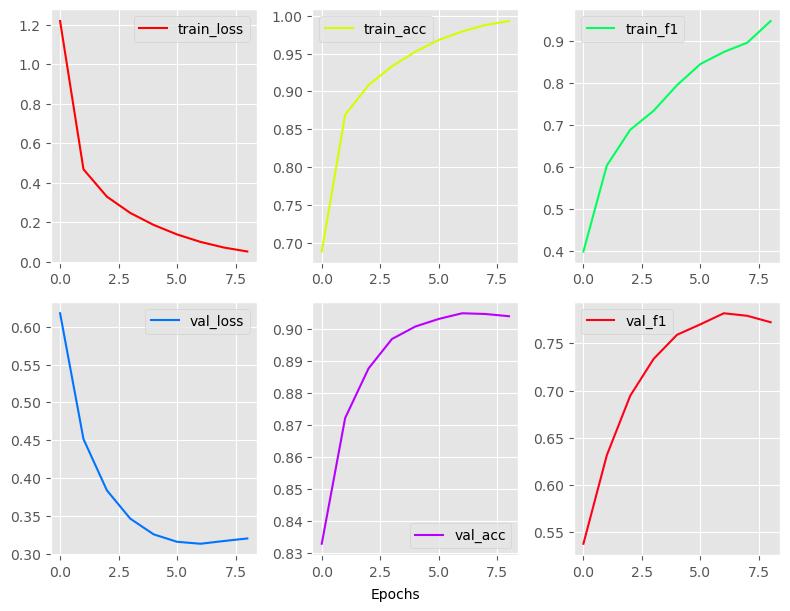

In [226]:
plot_history(bilstm_fc_model_history, nrows=2, ncols=3)

## BiGRU + FC

In [313]:
bigru_fc_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=True,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False
)
bigru_fc_model.init_weights()
print(f"The model has {bigru_fc_model.count_parameters():,} trainable parameters")

The model has 342,062 trainable parameters


In [230]:
bigru_fc_model_history = actual_train_val_test(bigru_fc_model, "bigru_fc_model",)


Early stopping...




Test loss: 0.264 | Test accuracy: 92.15% | Test F1: 83.86%


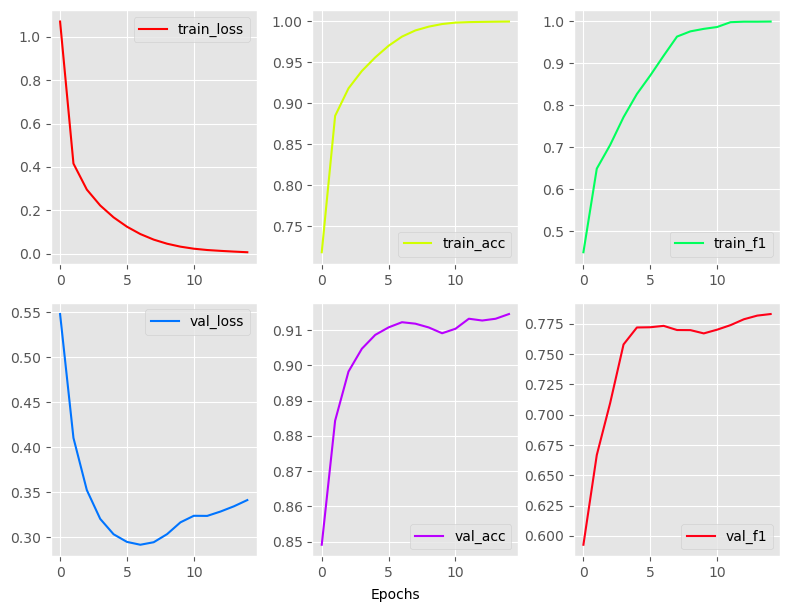

In [321]:
plot_history(bigru_fc_model_history, nrows=2, ncols=3)

## BiLSTMx2 + FC

In [314]:
bilstmx2_fc_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=2,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False
)
bilstmx2_fc_model.init_weights()
print(f"The model has {bilstmx2_fc_model.count_parameters():,} trainable parameters")

The model has 847,406 trainable parameters


In [234]:
bilstmx2_fc_model_history = actual_train_val_test(bilstmx2_fc_model, "bilstmx2_fc_model",)


Early stopping...




Test loss: 0.293 | Test accuracy: 91.59% | Test F1: 84.16%


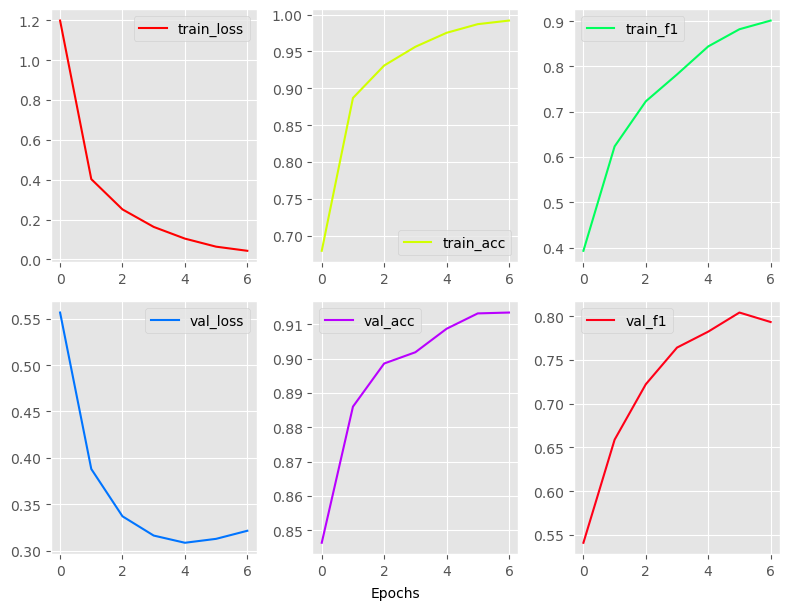

In [235]:
plot_history(bilstmx2_fc_model_history, nrows=2, ncols=3)

## BiLSTM + FC + CRF

In [315]:
bilstm_fc_crf_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=True,
)
bilstm_fc_crf_model.init_weights()
print(f"The model has {bilstm_fc_crf_model.count_parameters():,} trainable parameters")

The model has 454,350 trainable parameters


In [239]:
bilstm_fc_crf_model_history = actual_train_val_test(
    bilstm_fc_crf_model, "bilstm_fc_crf_model",
)


Early stopping...




Test loss: 52.851 | Test accuracy: 90.71% | Test F1: 83.87%


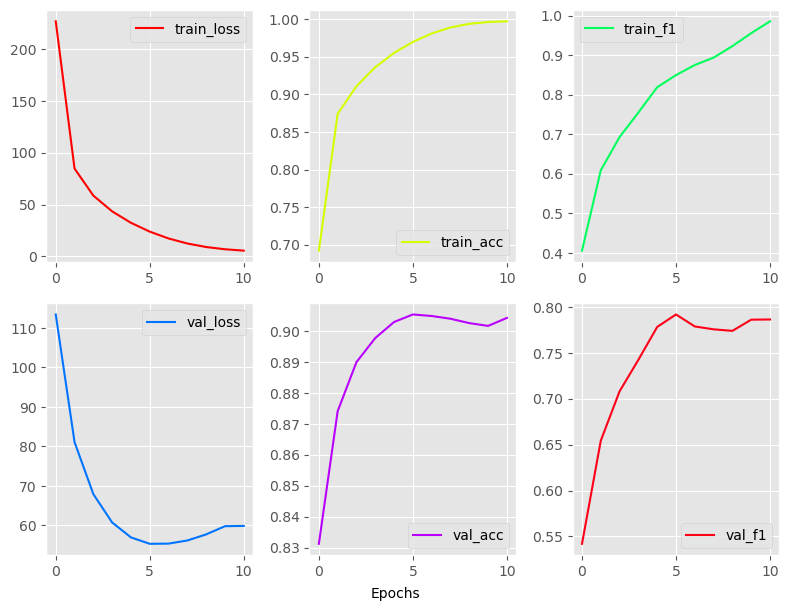

In [240]:
plot_history(bilstm_fc_crf_model_history, nrows=2, ncols=3)

## Conclusions

As we can see, early stopping kicks in on every tested instance: this means that it takes a relatively low amount of epochs to overfit the dataset on the training data. In particular, it seems that $10$/$15$ epochs of training are enough to observe good metrics and obtain great generalization.

Moreover, results from different models are comparable in terms of both accuracy and F1 macro, ranging from 90% to 92% for accuracy and from 83% to 85% for F1 on the test set. One thing that is not expected is that incrementing the complexity of the network architecture actually gives worse results w.r.t sticking to a simple model (even though, as already pointed out, results are very close with each other). 

## Error analysis

In this section we are going to try and understand what kind of errors our models are making and if they relate to the way we have developed our solutions$\dots$

The first type of expected error would be in recognizing proper nouns and in particular the ones referring to people's names. The reason why this is an expected error is because of our preprocessing step, where tokens are transformed to lowercase strings. My intuition is that capitalized words could be better recognizable by a POS tagger as proper nouns w.r.t. having to deal with plain lowercase tokens. Let's see if this intuition holds up$\dots$

First of all, we are going to consider an example sentence s.t. its entire token and tag set is present in our dataset, even though different tokens could be present in different splits.

In [338]:
pred_example_sentence = "Bob made a book collector happy the other day"
preprocessed_pred_example_sentence = [preprocess_token(t) for t in pred_example_sentence.split()]
preprocessed_pred_example_sentence

['bob', 'made', 'a', 'book', 'collector', 'happy', 'the', 'other', 'day']

In order to simplify the prediction process, we are going to build a small embedding matrix containing just the tokens we need. So, first of all, let's see if there are OOV terms$\dots$

In [345]:
check_oov_terms(embedding_model, preprocessed_pred_example_sentence)

set()

It seems that there are no OOV words w.r.t. pre-trained GloVe embeddings, so that we can simply extract them from the Gensim wrapper.

In [351]:
pred_embedding_matrix = torch.tensor(
    [embedding_model[t] for t in preprocessed_pred_example_sentence]
)
pred_embedding_matrix

tensor([[-0.0354,  0.5720,  0.0187,  ..., -0.6009, -0.0608,  0.1033],
        [ 0.1875,  0.1651, -0.0329,  ..., -0.3648, -0.6074,  0.2343],
        [-0.2971,  0.0940, -0.0967,  ...,  0.0597, -0.2285,  0.2960],
        ...,
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        [-0.1857,  0.4094,  0.0289,  ..., -0.5074, -0.2050, -0.0687],
        [-0.2450, -0.1249, -0.2536,  ..., -0.4107, -0.6193,  0.0039]])

Next, we are going to make a copy of the trained baseline model and inject into it the ad-hoc made embeddings$\dots$

In [360]:
pred_bilstm_fc_model = copy.deepcopy(bilstm_fc_model)
pred_bilstm_fc_model.inject_embeddings(pred_embedding_matrix)

Since our model expects a tensor of shape `(batch_size, max_sentence_size)` we are going to add a dimension to our indexed example sentence so as to simulate a mini-batch of size $1$. By the way, the indexes of the example sentence correspond to numbers $0\dots8$ since they refer to our custom embedding matrix.

In [361]:
indexed_pred_example_sentence = torch.tensor(
    list(range(len(preprocessed_pred_example_sentence))), dtype=torch.long
).unsqueeze(0)
indexed_pred_example_sentence

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8]])

Let's also index the ground truth tags, so as to compare them with the predicted ones$\dots$

In this example, ground truth data was generated manually and double-checked with [this online service](https://parts-of-speech.info/).

In [362]:
ground_truth = ["NNP", "VBD", "DT", "NN", "NN", "JJ", "DT", "JJ", "NN"]
indexed_ground_truth = torch.tensor(
    [tags_vocabulary.from_string[t] for t in ground_truth], dtype=torch.long
).unsqueeze(0)
indexed_ground_truth

tensor([[21, 36, 11, 20, 20, 15, 11, 15, 20]])

Finally, let's call the model and analyze its predictions$\dots$

In [363]:
predictions = pred_bilstm_fc_model.predict(indexed_pred_example_sentence)
indexed_predictions, indexed_ground_truth = get_best(predictions, indexed_ground_truth)
indexed_predictions

[21, 36, 11, 20, 20, 39, 11, 15, 20]

If we look close, we can see that only one token is misclassified, i.e. the $6$th token in the sentence (if we start to count from 1). Let's check the entity of the error$\dots$

In [367]:
print(
    f"The tag {tags_vocabulary.to_string[15]} was marked as {tags_vocabulary.to_string[39]}"
)

The tag JJ was marked as VBP


As we can see, our model picks up the token `happy` as a `VBP` (verb non-$3$rd person singular), while it should have classified the token as a `JJ` (adjective). Contrary to what we expected, the proper noun `bob` is correctly classified as `NNP` and strangely enough an adjective is mistaken for a verb.

Anyway, if we further think about it, the token `happy` can be easily misclassified as a `VBP` part-of-speech, since it could also play that role in other scenarios (which were probably seen during training): it seems that the model is not able to capture the "long-range" dependency related to the use of the token `made`, which in this sentence is the word acting as a verb.

## Other experiments

In this section we are going to experiment a little bit with the baseline model, to try and squeeze some extra F1 points out of it. In particular, to better validate our experiments we are going to completely remove early stopping, so that we can observe the entire learning curves (even though we are still saving the model that performed the best on the validation set).

In [385]:
NO_EARLY_STOPPING_PATIENCE = float("inf")
NO_EARLY_STOPPING_MIN_DELTA = float("inf")

### Clipping the norm of the gradient

As shown in [[2]](#2), clipping the norm of the gradient to a predefined value could improve performance on sequence labeling tasks and, more importantly, it can prevent the issue of exploding gradients (which is not solved by the use of LSTMs, since they only address the problem of vanishing gradients). In this experiment, we are limiting the norm of the gradient to the value $10$, since its seems a correct hyperparameter value, as reported in many papers.

In [386]:
bilstm_fc_clip_norm_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_clip_norm_model.init_weights()
print(
    f"The model has {bilstm_fc_clip_norm_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [387]:
bilstm_fc_clip_norm_model_history = actual_train_val_test(
    bilstm_fc_clip_norm_model,
    "bilstm_fc_clip_norm_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
    limit_gradients="norm",
)


Test loss: 0.328 | Test accuracy: 91.86% | Test F1: 84.88%


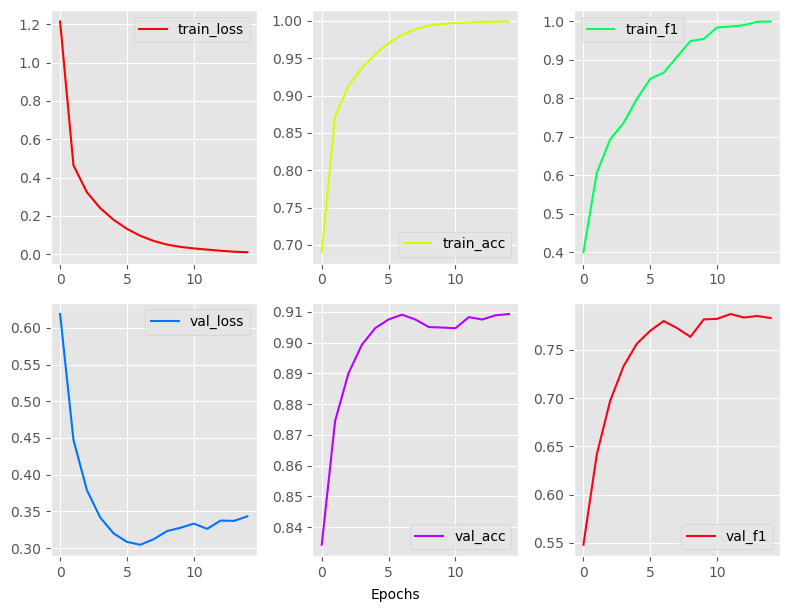

In [390]:
plot_history(bilstm_fc_clip_norm_model_history, nrows=2, ncols=3)

### Clamping the values of the gradient

Similarly to the previous experiment, the goal is still related to avoiding the issue of exploding gradients. In this experiment, we are instead limiting each gradient value to be in the range $[-1,1]$, since its seems a correct hyperparameter value, as reported in many papers.

In [391]:
bilstm_fc_clamp_values_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_clamp_values_model.init_weights()
print(
    f"The model has {bilstm_fc_clamp_values_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [392]:
bilstm_fc_clamp_values_model_history = actual_train_val_test(
    bilstm_fc_clamp_values_model,
    "bilstm_fc_clamp_values_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
    limit_gradients="values",
)


Test loss: 0.310 | Test accuracy: 91.74% | Test F1: 82.93%


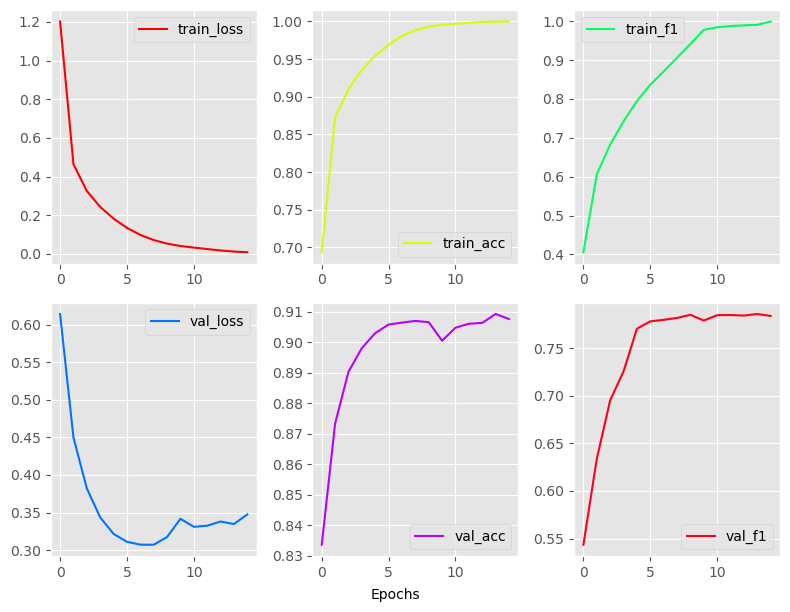

In [393]:
plot_history(bilstm_fc_clamp_values_model_history, nrows=2, ncols=3)

### Decreasing hidden sizes

As shown in [[2]](#2), the optimal hidden size for recurrent modules (in sequence labeling tasks) seems to be around $100$ dimensions. Since our initial hidden size was set at $128$, let's see if halving it could improve the results. Ideally, following the cited paper's reasoning, we should observe worse metrics w.r.t. our baseline model. Anyway, the paper also reports the following:

>The number of recurrent units, as long as it is
not far too large or far too small, has only a
minor effect on the results

So, let's see if this statement holds by checking whether our model gets worse or stays the same.

In [394]:
SMALL_HIDDEN_DIMENSION = 64

In [395]:
bilstm_fc_small_hidden_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    SMALL_HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_small_hidden_model.init_weights()
print(
    f"The model has {bilstm_fc_small_hidden_model.count_parameters():,} trainable parameters"
)

The model has 193,326 trainable parameters


In [396]:
bilstm_fc_small_hidden_model_history = actual_train_val_test(
    bilstm_fc_small_hidden_model,
    "bilstm_fc_small_hidden_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 0.270 | Test accuracy: 91.88% | Test F1: 82.27%


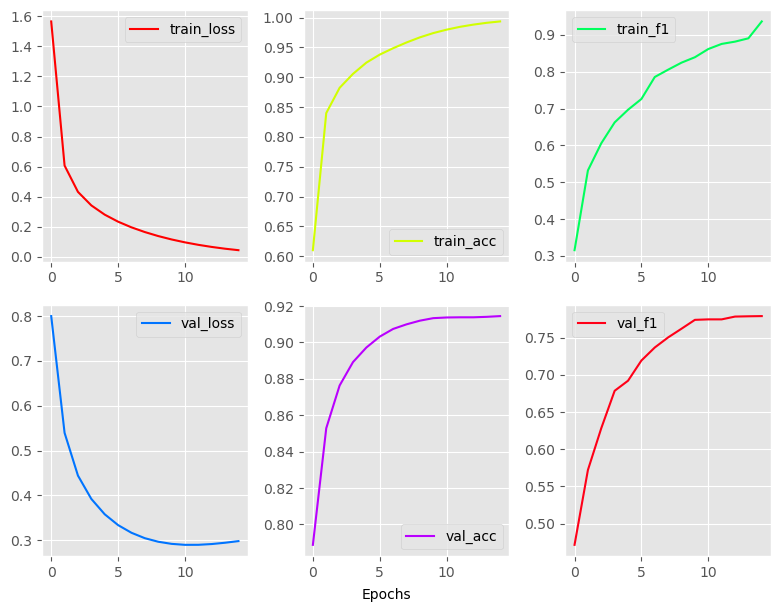

In [397]:
plot_history(bilstm_fc_small_hidden_model_history, nrows=2, ncols=3)

### Increasing hidden sizes

Let's perform the same test of the previous section, but the other way around, meaning that we are going to double the hidden dimension of the recurrent modules, w.r.t. the baseline model. Again, we shouldn't see neither big improvements nor big performance losses.

In [398]:
BIG_HIDDEN_DIMENSION = 256

In [399]:
bilstm_fc_big_hidden_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    BIG_HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_big_hidden_model.init_weights()
print(
    f"The model has {bilstm_fc_big_hidden_model.count_parameters():,} trainable parameters"
)

The model has 1,166,382 trainable parameters


In [400]:
bilstm_fc_big_hidden_model_history = actual_train_val_test(
    bilstm_fc_big_hidden_model,
    "bilstm_fc_big_hidden_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 0.391 | Test accuracy: 90.33% | Test F1: 82.65%


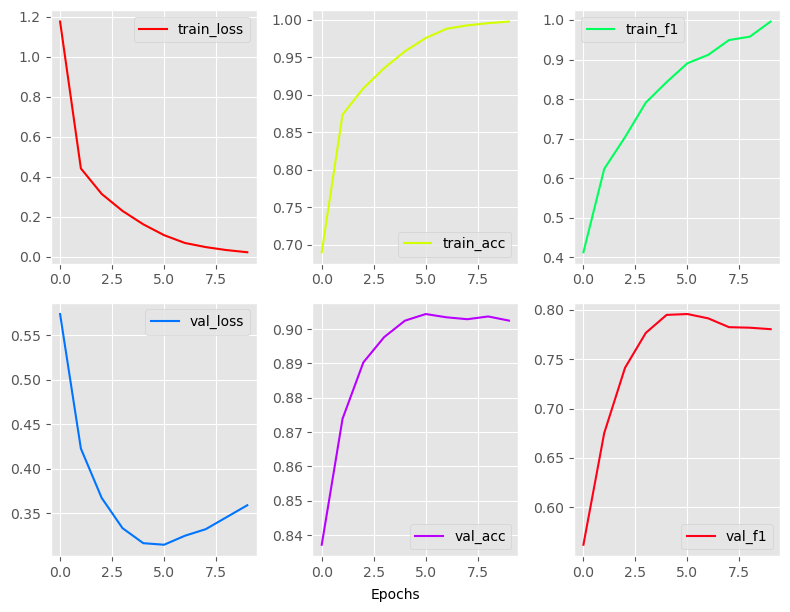

In [401]:
plot_history(bilstm_fc_model_big_hidden_history, nrows=2, ncols=3)

### Skipping normal weight initialization

As already mentioned above, during the creation of the `POSTaggingModel` object, we specified that each instance of that object would have a simple initialization scheme, given by a normal distribution with zero mean and a very small standard deviation of $0.01$. In this section we are going to create a new baseline model without initializing its weight to see if this step brings any benefit to the final results.

In [402]:
bilstm_fc_skip_init_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
print(
    f"The model has {bilstm_fc_skip_init_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [403]:
bilstm_fc_skip_init_model_history = actual_train_val_test(
    bilstm_fc_skip_init_model,
    "bilstm_fc_skip_init_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 0.302 | Test accuracy: 91.86% | Test F1: 85.30%


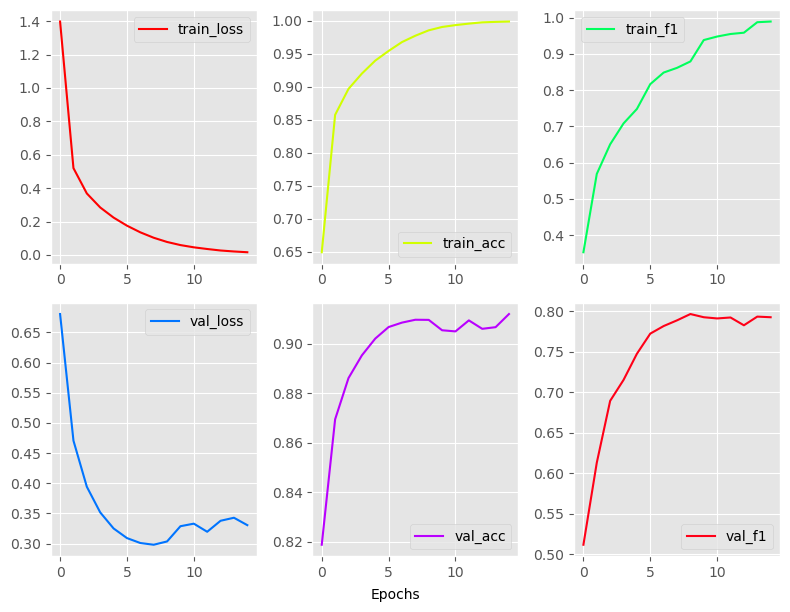

In [405]:
plot_history(bilstm_fc_skip_init_model_history, nrows=2, ncols=3)

### Trying dropout

A simple, yet effective, regularization technique is the one know in the literature as `dropout`. As also reported in [[2]](#2), its introduction in a model whose task is sequence labeling could bring some minor improvements. In particular, the paper refers to a variant of the standard dropout method known as `variational dropout`, which is not yet available on `PyTorch`: because of this, we are doing the experiment with the so-called `naive dropout`.

Moreover, the paper states the following:
> The best result was
achieved, when dropout was applied both to
the output units as well as to the recurrent
units of the LSTM networks

Because of this claim, we are applied dropout to both the output and the recurrent units.

In [406]:
DROPOUT_RATE = 0.25

In [407]:
bilstm_fc_dropout_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=DROPOUT_RATE,
    lr=LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_dropout_model.init_weights()
print(
    f"The model has {bilstm_fc_dropout_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [408]:
bilstm_fc_dropout_model_history = actual_train_val_test(
    bilstm_fc_dropout_model,
    "bilstm_fc_dropout_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 0.236 | Test accuracy: 92.81% | Test F1: 85.21%


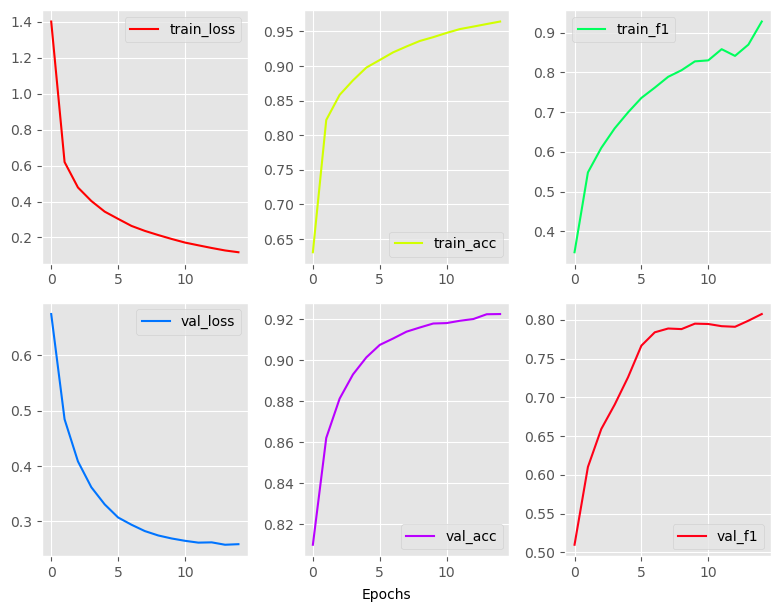

In [410]:
plot_history(bilstm_fc_dropout_model_history, nrows=2, ncols=3)

### Changing the optimizer

Another simple thing that could be changed is the optimizer. In every tested model so far, we are using the `Adam` optimizer with standard parameters, but maybe a simpler `RMSProp` optimizer could also be suited to the task. Still citing [[2]](#2):
> Adam and Adam with Nesterov momentum
(Nadam) usually performed the best, followed
by RMSProp. Adadelta and Adagrad had a
much higher variance in terms of test performance and resulted on average to far worse
results. SGD failed in a high number of cases
to converge to a minimum, likely due to its
high sensitivity of the learning rate

In [417]:
RMS_LEARNING_RATE = 1e-2

In [418]:
bilstm_fc_rms_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=RMS_LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_rms_model.init_weights()
print(
    f"The model has {bilstm_fc_rms_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [419]:
bilstm_fc_rms_model.optimizer = optim.RMSprop(
    bilstm_fc_rms_model.parameters(), lr=bilstm_fc_rms_model.lr, momentum=0.9
)

In [420]:
bilstm_fc_rms_model_history = actual_train_val_test(
    bilstm_fc_rms_model,
    "bilstm_fc_rms_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 0.673 | Test accuracy: 86.23% | Test F1: 78.10%


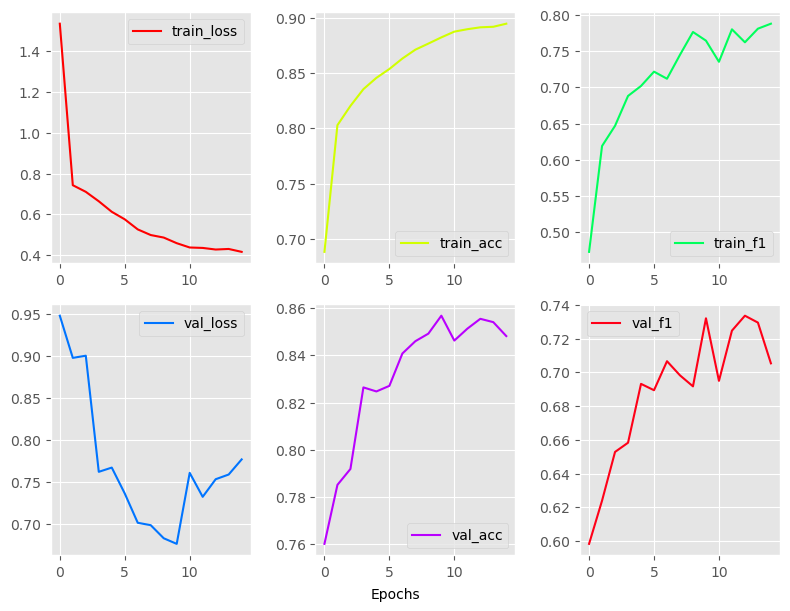

In [421]:
plot_history(bilstm_fc_rms_model_history, nrows=2, ncols=3)

The only difference that we observed by using `RMSProp` instead of `Adam` was that the former optimizer was much slower w.r.t. the latter. Other than that, final results are comparable with both optimizers. However, looking at the plots, we can observe less smooth curves, mostly regarding validation metrics (which means that we are probably overfitting a bit the training set, i.e. we are converging too fast to a local optimum).

### Using a learning rate schedule

The last experiment in this notebook is related to the usage of a learning rate schedule, s.t. the learning rate value is reduced after a specified number of epochs has passed. There are a lot of interesting decay methods that could be applied, but we decided to go for one of the simplest, i.e. the exponential decay, by setting a relatively high learning rate at the start of the training phase and gradually decreasing it by a multiplicative factor.

In [422]:
STARTING_LEARNING_RATE = 1.0
LR_SCHEDULER_GAMMA = 0.1

In [423]:
bilstm_fc_lr_schedule_model = POSTaggingModel(
    EMBEDDING_DIMENSION,
    HIDDEN_DIMENSION,
    len(tags_vocabulary.string),
    gru=False,
    num_layers=1,
    bidirectional=True,
    dropout_rate=0.0,
    lr=STARTING_LEARNING_RATE,
    padding_index=tags_vocabulary.from_string[PADDING_TOKEN],
    crf=False,
)
bilstm_fc_lr_schedule_model.init_weights()
print(
    f"The model has {bilstm_fc_lr_schedule_model.count_parameters():,} trainable parameters"
)

The model has 452,142 trainable parameters


In [424]:
bilstm_fc_lr_schedule_model.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    bilstm_fc_lr_schedule_model.optimizer, gamma=LR_SCHEDULER_GAMMA, last_epoch=-1
)

In [425]:
bilstm_fc_lr_schedule_model_history = actual_train_val_test(
    bilstm_fc_lr_schedule_model,
    "bilstm_fc_lr_schedule_model",
    es_patience=NO_EARLY_STOPPING_PATIENCE,
    es_min_delta=NO_EARLY_STOPPING_MIN_DELTA,
)


Test loss: 1.702 | Test accuracy: 70.50% | Test F1: 52.31%


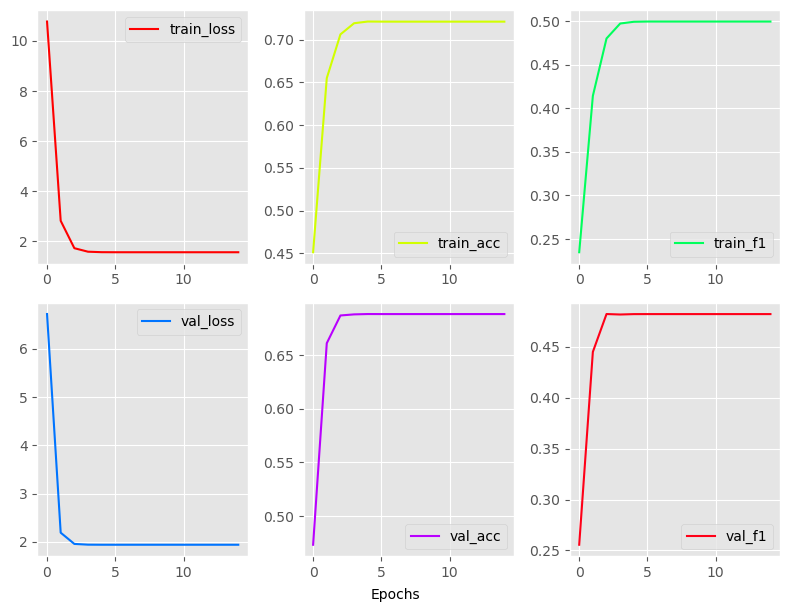

In [426]:
plot_history(bilstm_fc_lr_schedule_model_history, nrows=2, ncols=3)

Once again, final results are comparable to the baseline model, which uses a fixed learning rate throughout the entire learning phase.

## Final remarks

## References

- <a id="1">[1]</a>
  _Yuval Pinter, Robert Guthrie and Jacob Eisenstein (2017)_.\
  **Mimicking Word Embeddings using Subword RNNs**.\
  Proceedings of the 2017 Conference on Empirical Methods in Natural Language Processing.
- <a id="2">[2]</a>
  _Nils Reimers and Iryna Gurevych (2017)_.\
  **Optimal Hyperparameters for Deep LSTM-Networks for Sequence Labeling Tasks**.\
  CoRR journal, abs/1707.06799 volume.
- <a id="3">[3]</a>
  _Zhiheng Huang, Wei Xu and Kai Yu (2015)_.\
  **Bidirectional LSTM-CRF Models for Sequence Tagging**.